In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.io import loadmat
import pyriemann
from matplotlib import patches
from sklearn.neighbors import KernelDensity
from scipy.signal import find_peaks
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score, recall_score
from sklearn.utils import shuffle
from scipy.stats import norm
from sklearn.mixture import GaussianMixture

In [2]:
path="/home/sahaj432/Desktop/dataset/Simulator/C_Difficult1_noise005.mat" #Difficult

In [3]:
df=loadmat(path)

In [4]:
df_time=df["spike_times"][0][0][0]
df_spike=df["spike_class"][0][0]
df_raw=df["data"][0]

In [5]:
def min_max_normalize(signal):

    min_val = np.min(signal)
    max_val = np.max(signal)
    
    normalized_signal = (signal - min_val) / (max_val - min_val)
    return normalized_signal


In [6]:
df_rawn=min_max_normalize(df_raw)

In [7]:
t_spk1=df_time[np.where(df_spike==1)[1]]
t_spk2=df_time[np.where(df_spike==2)[1]]
t_spk3=df_time[np.where(df_spike==3)[1]]

print(f"no. of spike 1 = {len(t_spk1)}")
print(f"no. of spike 2 = {len(t_spk2)}")
print(f"no. of spike 3 = {len(t_spk3)}")

no. of spike 1 = 1115
no. of spike 2 = 1113
no. of spike 3 = 1155


In [8]:
def extract_raw(t_spk,raw):
    return np.array([raw[t_spk[i]:t_spk[i]+56] for i in range(len(t_spk))])

In [9]:
spk1=extract_raw(t_spk1,df_rawn)
spk2=extract_raw(t_spk2,df_rawn)
spk3=extract_raw(t_spk3,df_rawn)

In [10]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

for i in cov_ary:
    print(is_pos_def(i))

In [11]:

def find_rcs(x_in,select,select_1,random_ind,target):
    regulator=np.array([[0.000001,0],[0,0.000001]])
    x_cov = np.array([np.cov(target,i) for i in x_in]) + regulator
    
    labels_A = np.zeros(len(select), dtype=int)
    labels_B = np.ones(len(select_1), dtype=int)
    truth_labels = np.concatenate([labels_A, labels_B])
    
    
    print(random_ind)
    
    x_psd=np.array([is_pos_def(i) for i in x_cov])
    non_psd=np.where(x_psd==False)[0]
    print(np.where(x_psd==False))
    
    
    if len(non_psd)>1 :
        print("out")
        x_cov_new=np.delete(x_cov,non_psd, axis=0)
        x_new=np.delete(x_in,non_psd, axis=0)
        x_new_label=np.delete(truth_labels,non_psd, axis=0)
    elif len(non_psd)==0:
        print("in")
        x_cov_new=x_cov
        x_new=x
        x_new_label=truth_labels
    

    return x_new,x_new_label,x_cov_new #,radius,center,score

In [12]:
import math

def circle_area(radius):
    """Calculate the area of a circle given its radius."""
    return math.pi * radius ** 2

def intersection_area(circle1, circle2):
    """Calculate the area of intersection between two circles."""
    d = math.sqrt((circle1[0] - circle2[0]) ** 2 + (circle1[1] - circle2[1]) ** 2)
    r1, r2 = circle1[2], circle2[2]

    if d >= r1 + r2:  # No overlap
        return 0
    elif d <= abs(r1 - r2):  # Circle contained within the other
        return circle_area(min(r1, r2))
    else:
        # Calculate the area of intersection
        a = r1 ** 2 * math.acos((d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1))
        b = r2 ** 2 * math.acos((d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2))
        c = 0.5 * math.sqrt((-d + r1 + r2) * (d + r1 - r2) * (d - r1 + r2) * (d + r1 + r2))
        return a + b - c

def iou_circle(circle1, circle2):
    """Calculate the Intersection over Union (IoU) for two circles."""
    intersection = intersection_area(circle1, circle2)
    union = circle_area(circle1[2]) + circle_area(circle2[2]) - intersection
    #print(intersection / union)
    return intersection / union

def nms_circles(circles, iou_threshold):
    """
    Apply Non-Maximum Suppression (NMS) to a set of circles using IoU.

    :param circles: List of tuples (x, y, radius).
    :param iou_threshold: IoU threshold for considering circles as overlapping.
    :return: List of circles after applying NMS.
    """
    circles = sorted(circles, key=lambda x: x[2], reverse=True)  # Sort by radius
    selected_circles = []

    while circles:
        current = circles.pop(0)
        selected_circles.append(current)
        circles = [circle for circle in circles if iou_circle(current, circle) < iou_threshold]

    return selected_circles



select= spk1
select1= spk3



x=np.vstack((select,select1))
print(f"total x = {x.shape}")
print(f"no. of spike 1 = {len(spk1)}")
print(f"no. of spike 2 = {len(spk2)}")
print(f"no. of spike 3 = {len(spk3)}")

10
(array([], dtype=int64),)
in
--- 0.32848286628723145 seconds ---


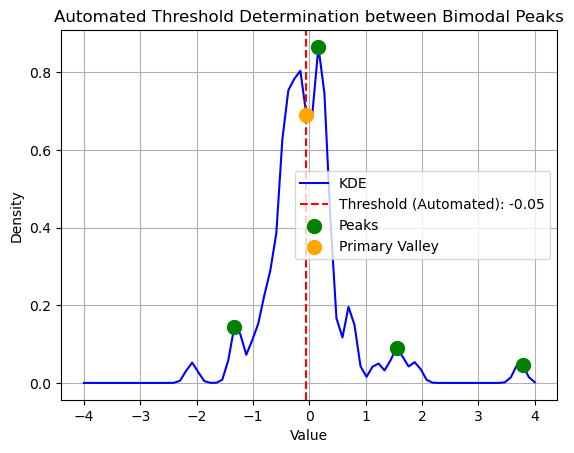

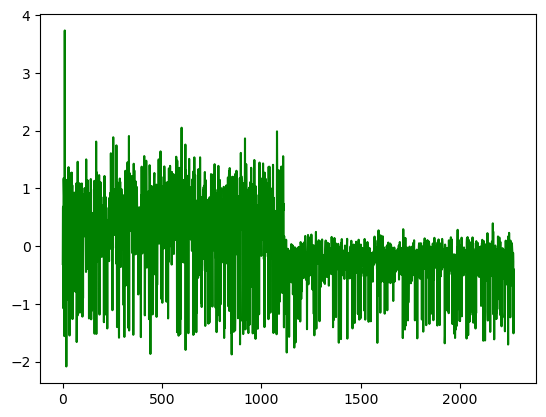

In [30]:
spkk1=spk1[:]
spkk2=spk3[:]


select= spkk1
select1= spkk2
x=np.vstack((select,select1))
#np.random.shuffle(x)
random_index = 10#1163#100#1163#1000 #1163 #np.random.randint(1000,2000)  #0,1000 #1000,2000
target= x[random_index]

import time
start_time = time.time()

x_test,y_test,x_cov_new=find_rcs(x,select,select1,random_index,target)  

tangent_fit=pyriemann.tangentspace.TangentSpace(metric='riemann')
instance_fit=tangent_fit.fit(x_cov_new)
tangent_out=instance_fit.fit_transform(x_cov_new)

radii=abs(tangent_out[:,2]) # variance of y
center=tangent_out[:,1] # covariance 
scores = abs(tangent_out[:,2]) # variance of y
#s=tangent_out[:,0]
data = list(zip(center, np.zeros(len(center)), scores))
selected_circles = nms_circles(data, 0.5)
kept_centers,_,kept_radii=zip(*selected_circles)

#print("Selected Circles:", selected_circles)
# kept_centers,kept_radii, _=nms_circles_separate_arrays(center, radii, scores, 0.9)
sample_data = np.asarray(kept_centers).reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(sample_data)
x_values = np.linspace(-4, 4, len(kept_centers)).reshape(-1, 1)
density_values = np.exp(kde.score_samples(x_values))
peaks, _ = find_peaks(density_values, distance=10)
valleys, _ = find_peaks(-density_values, distance=10)
if len(valleys) > 1:
    primary_valley = valleys[np.argmax(density_values[valleys])]
else:
    primary_valley = valleys[0]
threshold_value_auto = x_values[primary_valley][0]



print("--- %s seconds ---" % (time.time() - start_time))
plt.plot(x_values, density_values, label="KDE", color="blue")
plt.axvline(threshold_value_auto, color="red", linestyle="--", label=f"Threshold (Automated): {threshold_value_auto:.2f}")
plt.scatter(x_values[peaks], density_values[peaks], color="green", s=100, zorder=5, label="Peaks")
plt.scatter(threshold_value_auto, density_values[primary_valley], color="orange", s=100, zorder=5, label="Primary Valley")
plt.title("Automated Threshold Determination between Bimodal Peaks")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

#plt.plot(radii,color="black")
plt.plot(center,color="green")
#plt.plot(s,color="red")
plt.show()

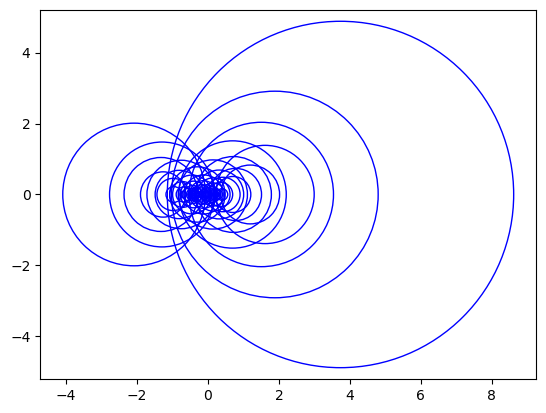

In [31]:
fig = plt.figure()
ax = fig.add_subplot()
for i in range(len(kept_centers)):
    circle1 = patches.Circle((kept_centers[i],0), radius=kept_radii[i], fc='none', ec='blue')
    ax.add_patch(circle1)
ax.axis('equal')
plt.show()

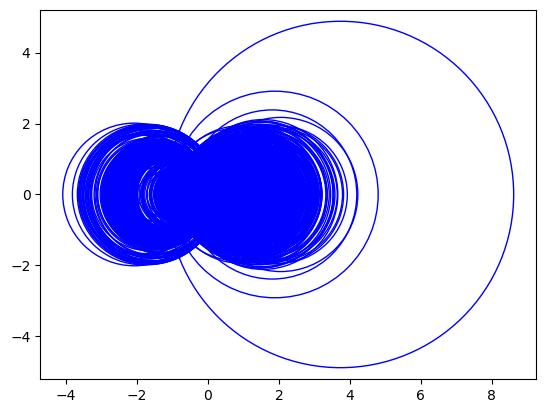

In [32]:
fig = plt.figure()
ax = fig.add_subplot()
for i in range(len(center)):
    circle1 = patches.Circle((center[i],0), radius=scores[i], fc='none', ec='blue')
    ax.add_patch(circle1)
ax.axis('equal')
plt.show()

In [33]:
print(np.mean(center[:1000]))
print(np.mean(center[-1000:]))
print(np.mean(center))
print(threshold_value_auto)

0.3340127312970381
-0.3167158912877404
-1.585585567884179e-09
-0.05333333333333323


In [34]:
select= spkk1
select1= spkk2
if np.mean(center[:1000])>0:
    labels_A = np.zeros(len(select), dtype=int)
    labels_B = np.ones(len(select1), dtype=int)
    truth_labels = np.concatenate([labels_A, labels_B])
    
else:
    labels_B = np.zeros(len(select), dtype=int)
    labels_A = np.ones(len(select1), dtype=int)
    truth_labels = np.concatenate([labels_A, labels_B])

In [35]:
##positive

cluster_labels=center<threshold_value_auto
accuracy = accuracy_score(truth_labels,cluster_labels)
conf_matrix = confusion_matrix(truth_labels, cluster_labels)
precision = precision_score(truth_labels, cluster_labels)
recall = recall_score(truth_labels, cluster_labels)
print(cluster_labels)
print(accuracy*100)
print(conf_matrix )

[ True False False ...  True  True  True]
79.8237885462555
[[880 235]
 [223 932]]


+++++cov----

In [36]:
from sklearn.metrics import accuracy_score,rand_score,v_measure_score,adjusted_rand_score,adjusted_mutual_info_score
from sklearn.metrics import jaccard_score

In [37]:
# Evaluate Accuracy with Adjusted Rand Index
adjusted_rand = adjusted_rand_score(truth_labels,cluster_labels)
print(f'Adjusted Rand Index: {adjusted_rand}')

adjusted_mutual = adjusted_mutual_info_score(truth_labels,cluster_labels)
print(f'Adjusted mutual_info: {adjusted_mutual}')

v_measure = v_measure_score(truth_labels,cluster_labels)
jaccard = jaccard_score(truth_labels,cluster_labels,average='micro')

print(f"v_measure Information: {v_measure}")
print(f"jaccard_score Information: {jaccard}")

Adjusted Rand Index: 0.3554994540642738
Adjusted mutual_info: 0.2742169265276861
v_measure Information: 0.27444780649706063
jaccard_score Information: 0.6642228739002932
